In [3]:
!conda install -c conda-forge folium=0.5.0 --yes # comment/uncomment if not yet installed.
!conda install -c conda-forge geopy --yes        # comment/uncomment if not yet installed

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

import requests # library to handle requests
import bs4 as bs
import urllib.request

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

In [4]:
url   = "https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul"

In [5]:
page  = urllib.request.urlopen(url).read()
soup  = bs.BeautifulSoup(page,'lxml')
table = soup.find("table",class_="wikitable")
header = [head.findAll(text=True)[0].strip() for head in table.find_all("th")]
data   = [[td.findAll(text=True)[0].strip() for td in tr.find_all("td")]
          for tr in table.find_all("tr")]
data    = [row for row in data if len(row) == 6] #I have 6 columns
raw_df = pd.DataFrame(data,columns=header)
raw_df = raw_df[:-4] #removing last 4 rows of unneccessary info.
raw_df = raw_df.drop(raw_df.columns[[4,5]], axis=1) #removing last 2 columns of unneccessary info.
raw_df = raw_df.replace(',','', regex=True) #removing commas from numbers
raw_df['Population (2019)'].astype(str).astype(float)
raw_df['Area (km²)'].astype(str).astype(float)
raw_df['Density (per km²)'].astype(str).astype(float) #converting from string to float
raw_df=raw_df.sort_values(by=['District','Population (2019)','Area (km²)','Density (per km²)'], ascending=[1,1,1,1]).reset_index(drop=True)
print(raw_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
District             39 non-null object
Population (2019)    39 non-null object
Area (km²)           39 non-null object
Density (per km²)    39 non-null object
dtypes: object(4)
memory usage: 1.3+ KB
None


In [194]:
raw_df.head()

,District,Latitude,Longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.184182,28.740729
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bahçelievler,41.000290,28.863745


In [7]:
geolocator = Nominatim(user_agent='My-IBMNotebook')
lokasyon=[]
lat=[]
lon=[]
for x in range(0, len(raw_df)):#some district names like Şile gets mistaken for Chile so we add Istanbul next to them.
    lokasyon.append(raw_df.loc[x,'District']+', Istanbul')
for r in range(0, len(raw_df)):
    location = geolocator.geocode(lokasyon[r])
    lat.append(location.latitude)
    lon.append(location.longitude)

In [8]:
map(float, lat)#converting to float
map(float, lon)
raw_df = raw_df.assign(Latitude = lat) #adding lat and lon values for districts
raw_df = raw_df.assign(Longitude = lon)
raw_df = raw_df.drop(raw_df.columns[[1,2,3]], axis=1) #should've done this earlier, but firmly decided not to use population now, so, off they go.

In [9]:
raw_df.to_csv('istanbul_district_latlon.csv',index=False) #storing into a csv for proper use, whatever that means.

In [10]:
ist = pd.read_csv('istanbul_district_latlon.csv')

In [11]:
ist.head()

,District,Latitude,Longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.184182,28.740729
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bahçelievler,41.000290,28.863745


In [12]:
#getting the coordinates for Istanbul for map creation
address = 'Istanbul Turkey'

locationist = geolocator.geocode(address)
latitudist = locationist.latitude
longitudist = locationist.longitude
print('The geograpical coordinates for Istanbul are {}, {}.'.format(latitudist, longitudist))

The geograpical coordinates for Istanbul are 41.0096334, 28.9651646.


In [13]:
#creating a map of Istanbul with Districts
map_istanbul = folium.Map(location=[latitudist, longitudist], zoom_start=10)

# add markers to map
for lat, lng, label in zip(ist['Latitude'], ist['Longitude'], ist['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
    ).add_to(map_istanbul)
map_istanbul

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:

# Get the venue names and store it in a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=20000):#20km radius to filter every possible option since we are dealing with districts.
                                                                #Since we also deal with islands 20km is overkill, but would give an idea anyway.
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # creating API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [16]:
ist_venues=getNearbyVenues(names=ist['District'], latitudes=ist['Latitude'],longitudes=ist['Longitude'])

In [99]:
#filtering results with parks only
ist_park=ist_venues[ist_venues['Venue Category'].str.contains('Park')]
#and forests
ist_orman=ist_venues[ist_venues['Venue Category'].str.contains('Forest')] 
#and gardens
ist_bahce=ist_venues[ist_venues['Venue Category'].str.contains('Garden')] 
#and dogruns eventghough you may not be a dog person
ist_dog=ist_venues[ist_venues['Venue Category'].str.contains('Dog')] 
#and farms considering they are places that you can refresh
ist_cift=ist_venues[ist_venues['Venue Category'].str.contains('Farm')] 
#and parkours where you can take a walk that may be alongside a greenspace
ist_parkur=ist_venues[ist_venues['Venue Category'].str.startswith('Field')]
#I am pushin the boundaries and counting mountain tops as green spaces too.
ist_dag=ist_venues[ist_venues['Venue Category'].str.contains('Mountain')] 
#In the context of green spaces, cemeteries are also in the mix, but I assume no one would go to a cemetery to get a breath of fresh air.

ist_green=ist_park #creating a dataframe where all of them are listed.
ist_green=ist_green.append(ist_orman)
ist_green=ist_green.append(ist_bahce)
ist_green=ist_green.append(ist_dag)
ist_green=ist_green.append(ist_cift)
ist_green=ist_green.append(ist_dog)
ist_green=ist_green.append(ist_parkur)

In [100]:
#reseting the indexing for the dataframe
ist_green=ist_green.sort_values(by=['District','District Latitude','District Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category'], ascending=[1,1,1,1,1,1,1]).reset_index(drop=True)

In [196]:
ist_green.to_csv('istanbul_greenspaces.csv',index=False) #storing into a csv for proper use, whatever that means.

In [104]:
print('There are {} unique venues.'.format(len(ist_green['Venue'].unique()))) #No of unique green spaces

There are 34 unique venues.


In [103]:
#lets see the map where these greens are located
for lat, lng, label in zip(ist_green['Venue Latitude'], ist_green['Venue Longitude'], ist_green['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
    ).add_to(map_istanbul)
map_istanbul

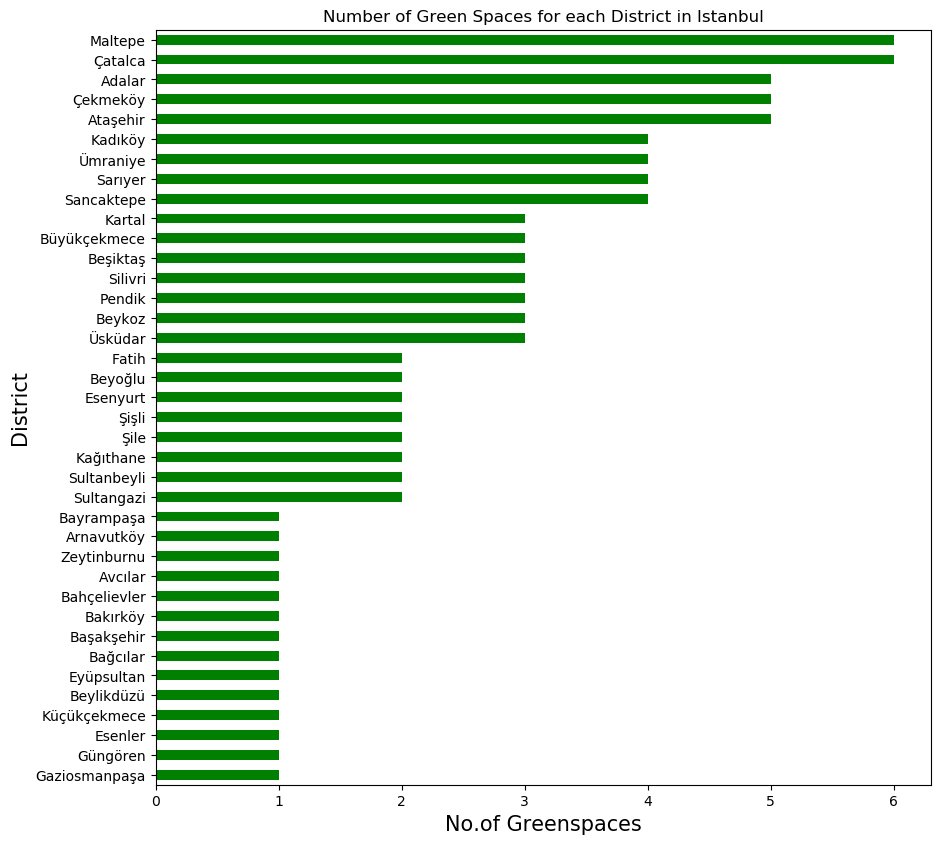

In [130]:
#The venues are not unique to their respective districts, lets see which district has more greenspace.

plt.figure(figsize=(10,10), dpi = 100)
plt.title('Number of Green Spaces for each District in Istanbul')
#On x-axis
plt.xlabel('No.of Greenspaces', fontsize = 15)
#On y-axis
plt.ylabel('District Name', fontsize=15)
#giving a bar plot
ist_green.groupby('District')['Venue'].count().sort_values(ascending=True).plot(kind='barh',color='green')
#displays the plot
plt.show()

In [193]:
# one hot encoding
ist_onehot = pd.get_dummies(ist_green[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
ist_onehot['District'] = ist_green['District'] 

# move district column to the first column
fixed_columns = [ist_onehot.columns[-1]] + list(ist_onehot.columns[:-1])
ist_onehot = ist_onehot[fixed_columns]

# Regroup rows by district and mean of frequency occurrence per category.
ist_grouped = ist_onehot.groupby('District').mean().reset_index()

In [197]:
ist_grouped.to_csv('istanbul_greenspaces_freq_district.csv',index=False) #storing into a csv for proper use, whatever that means.

In [188]:
# set number of clusters
kclusters = 6
ist_grouped_clustering =ist_grouped.drop('District', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(ist_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

[2 4 1 3 3 3 1 3 3 5]


In [181]:
ist_sorted = ist.set_index("District")
ist_merged = ist_grouped.set_index("District")
ist_merged['Cluster Labels'] = kmeans.labels_
ist_merged = ist_merged.join(ist_sorted)

In [191]:
# create map
map_clusters = folium.Map(location=[latitudist, longitudist], tiles="Openstreetmap", zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ist_merged['Latitude'], ist_merged['Longitude'], ist_merged.index.values,kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)       
map_clusters